# 2. GRI Calculation Example

This notebook demonstrates how to calculate the Global Representativeness Index (GRI) and Diversity Score using the processed benchmark data and cleaned survey data.

## Overview

The **GRI Scorecard** provides a comprehensive assessment of survey representativeness across three key dimensions:
1. **Country × Gender × Age**
2. **Country × Religion**
3. **Country × Environment (Urban/Rural)**

For each dimension, we calculate two complementary metrics:

### GRI Score (Proportional Accuracy)
- Measures how well sample proportions match true population proportions
- Range: 0.0 (complete mismatch) to 1.0 (perfect match)
- Based on Total Variation Distance: GRI = 1 - 0.5 × Σ|sample_proportion - population_proportion|

### Diversity Score (Coverage Breadth)
- Measures what percentage of relevant population strata are represented in the sample
- Range: 0.0 (no coverage) to 1.0 (complete coverage)
- Uses dynamic threshold X = 1/(2N) to define "relevant" strata
- Formula: (# strata with participants AND above threshold) / (# strata above threshold)

**Both metrics are essential**: GRI measures proportional accuracy while Diversity measures representational breadth.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add the gri module to the path
sys.path.append('..')
from gri.calculator import calculate_gri, calculate_diversity_score
from gri.utils import load_data

# Set plotting style
plt.style.use('default')
sns.set_palette('husl')

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## 1. Load Data

In [2]:
# Load benchmark data
benchmark_age_gender = load_data('../data/processed/benchmark_country_gender_age.csv')
benchmark_religion = load_data('../data/processed/benchmark_country_religion.csv')
benchmark_environment = load_data('../data/processed/benchmark_country_environment.csv')

# Load cleaned survey data
survey_data = load_data('../data/processed/sample_survey_data.csv')

print(f"Survey data loaded: {len(survey_data)} participants")
print(f"Benchmark data loaded: {len(benchmark_age_gender):,} age/gender + {len(benchmark_religion):,} religion + {len(benchmark_environment):,} environment strata")

Survey data loaded: 500 participants
Benchmark data loaded: 2,699 age/gender + 1,654 religion + 509 environment strata


## 2. Calculate GRI for Country × Gender × Age

In [3]:
# Calculate GRI for Country × Gender × Age dimension
strata_cols_age_gender = ['country', 'gender', 'age_group']

gri_age_gender = calculate_gri(
    survey_data, 
    benchmark_age_gender, 
    strata_cols_age_gender
)

diversity_age_gender = calculate_diversity_score(
    survey_data,
    benchmark_age_gender,
    strata_cols_age_gender
)

print("Country × Gender × Age Results:")
print(f"  GRI Score: {gri_age_gender:.4f}")
print(f"  Diversity Score: {diversity_age_gender:.4f}")

# Show sample proportions vs benchmark for context
sample_counts = survey_data.groupby(strata_cols_age_gender).size().reset_index(name='count')
sample_counts['sample_proportion'] = sample_counts['count'] / len(survey_data)

print(f"\nSample includes {len(sample_counts)} unique strata combinations")
print("Top 5 most represented strata in sample:")
print(sample_counts.nlargest(5, 'sample_proportion')[['country', 'gender', 'age_group', 'sample_proportion']])

Country × Gender × Age Results:
  GRI Score: 0.2613
  Diversity Score: 0.3353

Sample includes 71 unique strata combinations
Top 5 most represented strata in sample:
                     country  gender age_group  sample_proportion
4                     Brazil  Female     56-65              0.030
68  United States of America    Male     46-55              0.030
61  United States of America  Female     26-35              0.026
60  United States of America  Female     18-25              0.024
14                   Germany  Female     36-45              0.022


## 3. Calculate GRI for Country × Religion

In [4]:
# Calculate GRI for Country × Religion dimension
strata_cols_religion = ['country', 'religion']

gri_religion = calculate_gri(
    survey_data,
    benchmark_religion,
    strata_cols_religion
)

diversity_religion = calculate_diversity_score(
    survey_data,
    benchmark_religion,
    strata_cols_religion
)

print("Country × Religion Results:")
print(f"  GRI Score: {gri_religion:.4f}")
print(f"  Diversity Score: {diversity_religion:.4f}")

# Show sample religious distribution
religion_dist = survey_data['religion'].value_counts(normalize=True)
print("\nSample religious distribution:")
for religion, prop in religion_dist.head().items():
    print(f"  {religion}: {prop:.3f}")

Country × Religion Results:
  GRI Score: 0.0681
  Diversity Score: 0.1190

Sample religious distribution:
  Islam: 0.166
  Judaism: 0.160
  Christianity: 0.154
  Hinduism: 0.150
  I do not identify with any religious group or faith: 0.134


## 4. Calculate GRI for Country × Environment

In [5]:
# Calculate GRI for Country × Environment dimension
strata_cols_environment = ['country', 'environment']

gri_environment = calculate_gri(
    survey_data,
    benchmark_environment,
    strata_cols_environment
)

diversity_environment = calculate_diversity_score(
    survey_data,
    benchmark_environment,
    strata_cols_environment
)

print("Country × Environment Results:")
print(f"  GRI Score: {gri_environment:.4f}")
print(f"  Diversity Score: {diversity_environment:.4f}")

# Show sample environment distribution
env_dist = survey_data['environment'].value_counts(normalize=True)
print("\nSample environment distribution:")
for env, prop in env_dist.items():
    print(f"  {env}: {prop:.3f}")

Country × Environment Results:
  GRI Score: 0.0899
  Diversity Score: 0.0990

Sample environment distribution:
  Rural: 0.512
  Urban: 0.488


## 5. GRI Scorecard Summary

**Understanding the Metrics:**
- **GRI Score**: Proportional accuracy (higher = better match to population proportions)
- **Diversity Score**: Coverage breadth (higher = more demographic strata represented)
- **Dynamic Threshold**: With N=500 participants, relevant threshold = 1/(2×500) = 0.001 (0.1% population)

In [6]:
# Create GRI Scorecard
scorecard = pd.DataFrame({
    'Dimension': ['Country × Gender × Age', 'Country × Religion', 'Country × Environment'],
    'GRI Score': [gri_age_gender, gri_religion, gri_environment],
    'Diversity Score': [diversity_age_gender, diversity_religion, diversity_environment]
})

# Calculate Average GRI
average_gri = scorecard['GRI Score'].mean()
average_diversity = scorecard['Diversity Score'].mean()

print("=== GRI SCORECARD ===")
print(scorecard.to_string(index=False, float_format='%.4f'))
print(f"\nAverage GRI: {average_gri:.4f}")
print(f"Average Diversity Score: {average_diversity:.4f}")

# Interpretation
print("\n=== INTERPRETATION ===")
if average_gri >= 0.8:
    gri_interpretation = "Excellent representativeness"
elif average_gri >= 0.6:
    gri_interpretation = "Good representativeness"
elif average_gri >= 0.4:
    gri_interpretation = "Moderate representativeness"
else:
    gri_interpretation = "Poor representativeness"

if average_diversity >= 0.8:
    diversity_interpretation = "Excellent diversity coverage"
elif average_diversity >= 0.6:
    diversity_interpretation = "Good diversity coverage"
elif average_diversity >= 0.4:
    diversity_interpretation = "Moderate diversity coverage"
else:
    diversity_interpretation = "Poor diversity coverage"

print(f"Overall Assessment: {gri_interpretation}")
print(f"Coverage Assessment: {diversity_interpretation}")

=== GRI SCORECARD ===
             Dimension  GRI Score  Diversity Score
Country × Gender × Age     0.2613           0.3353
    Country × Religion     0.0681           0.1190
 Country × Environment     0.0899           0.0990

Average GRI: 0.1397
Average Diversity Score: 0.1845

=== INTERPRETATION ===
Overall Assessment: Poor representativeness
Coverage Assessment: Poor diversity coverage


## 6. Visualize Results

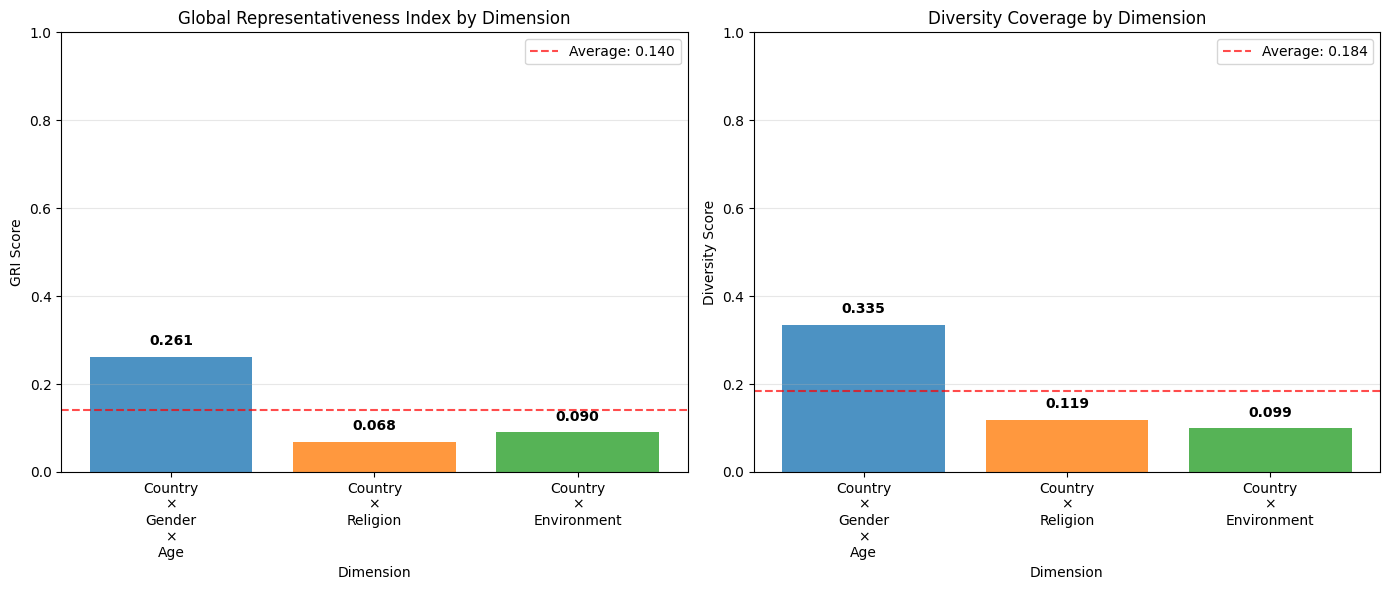

In [7]:
# Create visualization of GRI scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# GRI Scores bar chart
bars1 = ax1.bar(range(len(scorecard)), scorecard['GRI Score'], 
                color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)
ax1.axhline(y=average_gri, color='red', linestyle='--', alpha=0.7, label=f'Average: {average_gri:.3f}')
ax1.set_xlabel('Dimension')
ax1.set_ylabel('GRI Score')
ax1.set_title('Global Representativeness Index by Dimension')
ax1.set_xticks(range(len(scorecard)))
ax1.set_xticklabels([d.replace(' × ', '\n×\n') for d in scorecard['Dimension']], rotation=0, ha='center')
ax1.set_ylim(0, 1)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# Diversity Scores bar chart
bars2 = ax2.bar(range(len(scorecard)), scorecard['Diversity Score'], 
                color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)
ax2.axhline(y=average_diversity, color='red', linestyle='--', alpha=0.7, label=f'Average: {average_diversity:.3f}')
ax2.set_xlabel('Dimension')
ax2.set_ylabel('Diversity Score')
ax2.set_title('Diversity Coverage by Dimension')
ax2.set_xticks(range(len(scorecard)))
ax2.set_xticklabels([d.replace(' × ', '\n×\n') for d in scorecard['Dimension']], rotation=0, ha='center')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Sample Distribution Analysis

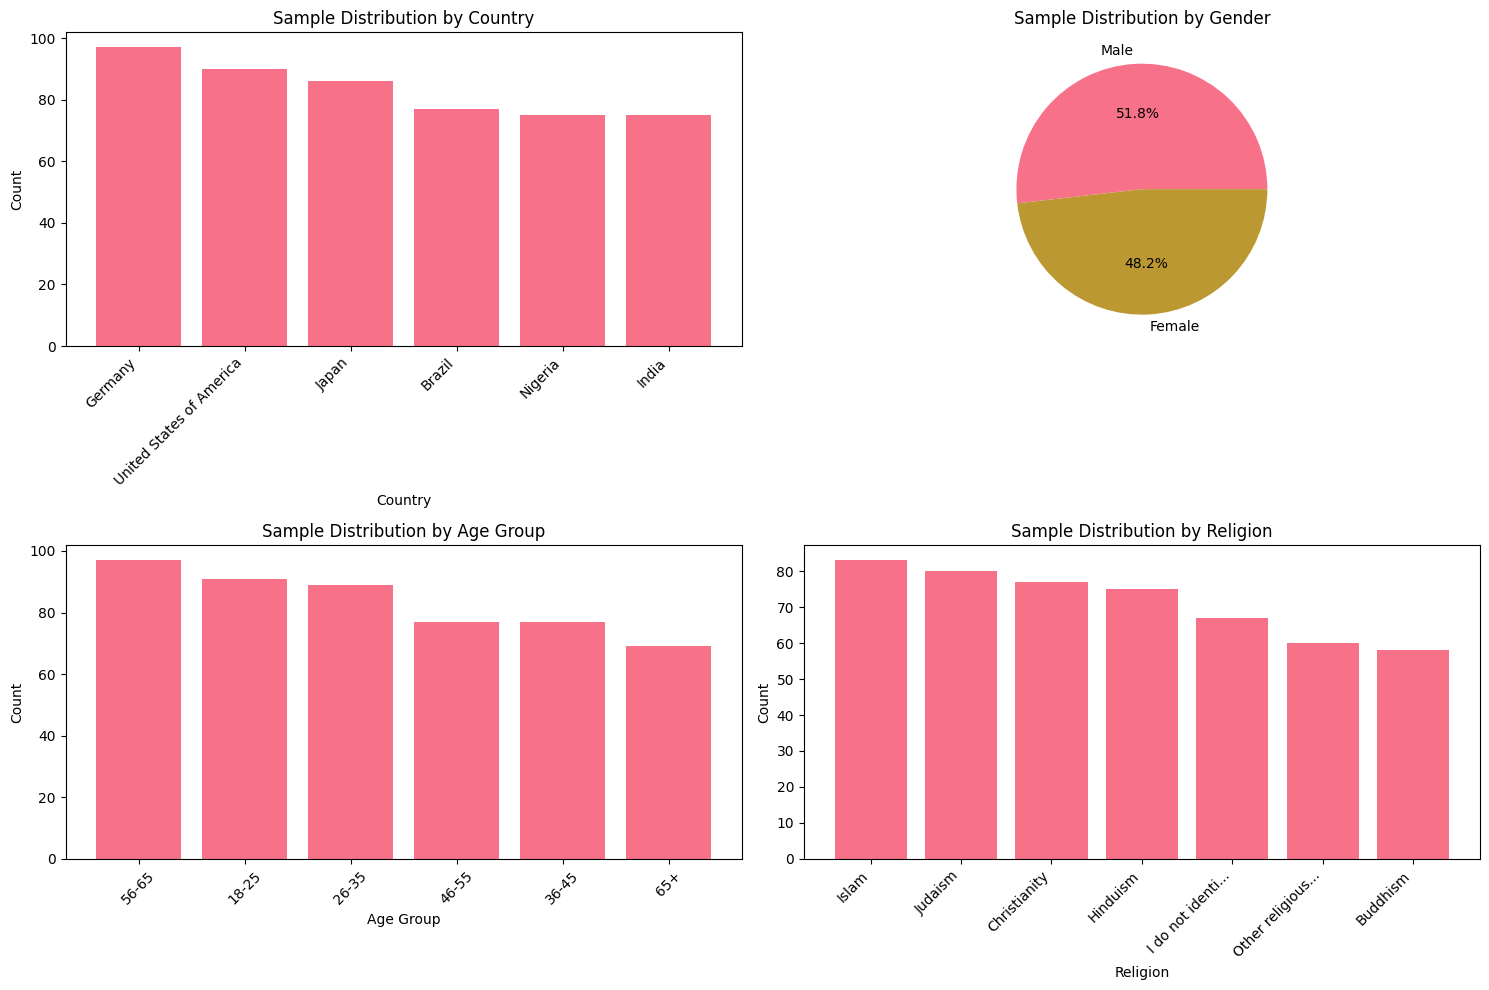

In [8]:
# Analyze sample composition
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Country distribution
country_counts = survey_data['country'].value_counts()
axes[0,0].bar(range(len(country_counts)), country_counts.values)
axes[0,0].set_title('Sample Distribution by Country')
axes[0,0].set_xlabel('Country')
axes[0,0].set_ylabel('Count')
axes[0,0].set_xticks(range(len(country_counts)))
axes[0,0].set_xticklabels(country_counts.index, rotation=45, ha='right')

# Gender distribution
gender_counts = survey_data['gender'].value_counts()
axes[0,1].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%')
axes[0,1].set_title('Sample Distribution by Gender')

# Age distribution
age_counts = survey_data['age_group'].value_counts()
axes[1,0].bar(range(len(age_counts)), age_counts.values)
axes[1,0].set_title('Sample Distribution by Age Group')
axes[1,0].set_xlabel('Age Group')
axes[1,0].set_ylabel('Count')
axes[1,0].set_xticks(range(len(age_counts)))
axes[1,0].set_xticklabels(age_counts.index, rotation=45)

# Religion distribution
religion_counts = survey_data['religion'].value_counts()
axes[1,1].bar(range(len(religion_counts)), religion_counts.values)
axes[1,1].set_title('Sample Distribution by Religion')
axes[1,1].set_xlabel('Religion')
axes[1,1].set_ylabel('Count')
axes[1,1].set_xticks(range(len(religion_counts)))
axes[1,1].set_xticklabels([r[:15] + '...' if len(r) > 15 else r for r in religion_counts.index], 
                          rotation=45, ha='right')

plt.tight_layout()
plt.show()

## 8. Save Results

In [9]:
# Save GRI results
results = {
    'survey_participants': len(survey_data),
    'gri_country_gender_age': gri_age_gender,
    'gri_country_religion': gri_religion,
    'gri_country_environment': gri_environment,
    'average_gri': average_gri,
    'diversity_country_gender_age': diversity_age_gender,
    'diversity_country_religion': diversity_religion,
    'diversity_country_environment': diversity_environment,
    'average_diversity': average_diversity,
    'assessment': gri_interpretation,
    'coverage_assessment': diversity_interpretation
}

# Save as JSON
import json
with open('../data/processed/gri_results.json', 'w') as f:
    json.dump(results, f, indent=2)

# Save scorecard as CSV
scorecard_extended = scorecard.copy()
scorecard_extended.loc[len(scorecard_extended)] = ['AVERAGE', average_gri, average_diversity]
scorecard_extended.to_csv('../data/processed/gri_scorecard.csv', index=False)

print("Results saved:")
print("  - data/processed/gri_results.json")
print("  - data/processed/gri_scorecard.csv")

Results saved:
  - data/processed/gri_results.json
  - data/processed/gri_scorecard.csv


## Summary

In this notebook, we have:

1. ✅ Calculated GRI scores for all three scorecard dimensions
2. ✅ Calculated diversity scores showing coverage breadth
3. ✅ Created a comprehensive GRI Scorecard
4. ✅ Visualized results with clear charts
5. ✅ Analyzed sample composition and distributions
6. ✅ Saved results for further analysis

**Next Steps:**
- Use `3-advanced-analysis.ipynb` to identify specific representativeness gaps
- Compare results across different surveys or time periods
- Use insights to improve future data collection targeting

**Files Created:**
- `data/processed/gri_results.json` - Complete results in JSON format
- `data/processed/gri_scorecard.csv` - Scorecard table for reporting